In [1]:
!pip install -q mediapipe
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


# Point Labelling Facial Landmark Data
Modify landmark detection function to label certain points on the face

In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow



In [3]:
from typing import List


class Connection:

    start = 0
    end = 0
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def getValues(self):
        return self.start, self.end


class AnatomyMap:
    def face_map_list(self):
        face_map = []
        for each in self.__class__.__dict__.keys():
            if each not in ['__module__', '__annotations__','__dict__', '__weakref__', '__doc__','face_map_list']:
                face_map.append(each)
        return face_map

    LIPS = [
        Connection(61, 146),
        Connection(146, 91),
        Connection(91, 181),
        Connection(181, 84),
        Connection(84, 17),
        Connection(17, 314),
        Connection(314, 405),
        Connection(405, 321),
        Connection(321, 375),
        Connection(375, 291),
        Connection(61, 185),
        Connection(185, 40),
        Connection(40, 39),
        Connection(39, 37),
        Connection(37, 0),
        Connection(0, 267),
        Connection(267, 269),
        Connection(269, 270),
        Connection(270, 409),
        Connection(409, 291),
        Connection(78, 95),
        Connection(95, 88),
        Connection(88, 178),
        Connection(178, 87),
        Connection(87, 14),
        Connection(14, 317),
        Connection(317, 402),
        Connection(402, 318),
        Connection(318, 324),
        Connection(324, 308),
        Connection(78, 191),
        Connection(191, 80),
        Connection(80, 81),
        Connection(81, 82),
        Connection(82, 13),
        Connection(13, 312),
        Connection(312, 311),
        Connection(311, 310),
        Connection(310, 415),
        Connection(415, 308),
    ]

    LEFT_EYE: List[Connection] = [
        Connection(263, 249),
        Connection(249, 390),
        Connection(390, 373),
        Connection(373, 374),
        Connection(374, 380),
        Connection(380, 381),
        Connection(381, 382),
        Connection(382, 362),
        Connection(263, 466),
        Connection(466, 388),
        Connection(388, 387),
        Connection(387, 386),
        Connection(386, 385),
        Connection(385, 384),
        Connection(384, 398),
        Connection(398, 362),
    ]

    LEFT_EYEBROW: List[Connection] = [
        Connection(276, 283),
        Connection(283, 282),
        Connection(282, 295),
        Connection(295, 285),
        Connection(300, 293),
        Connection(293, 334),
        Connection(334, 296),
        Connection(296, 336),
    ]

    LEFT_IRIS: List[Connection] = [
        Connection(474, 475),
        Connection(475, 476),
        Connection(476, 477),
        Connection(477, 474),
    ]

    RIGHT_EYE: List[Connection] = [
        Connection(33, 7),
        Connection(7, 163),
        Connection(163, 144),
        Connection(144, 145),
        Connection(145, 153),
        Connection(153, 154),
        Connection(154, 155),
        Connection(155, 133),
        Connection(33, 246),
        Connection(246, 161),
        Connection(161, 160),
        Connection(160, 159),
        Connection(159, 158),
        Connection(158, 157),
        Connection(157, 173),
        Connection(173, 133),
    ]

    RIGHT_EYEBROW: List[Connection] = [
        Connection(46, 53),
        Connection(53, 52),
        Connection(52, 65),
        Connection(65, 55),
        Connection(70, 63),
        Connection(63, 105),
        Connection(105, 66),
        Connection(66, 107),
    ]

    RIGHT_IRIS: List[Connection] = [
        Connection(469, 470),
        Connection(470, 471),
        Connection(471, 472),
        Connection(472, 469),
    ]

    FACE_OVAL: List[Connection] = [
        Connection(10, 338),
        Connection(338, 297),
        Connection(297, 332),
        Connection(332, 284),
        Connection(284, 251),
        Connection(251, 389),
        Connection(389, 356),
        Connection(356, 454),
        Connection(454, 323),
        Connection(323, 361),
        Connection(361, 288),
        Connection(288, 397),
        Connection(397, 365),
        Connection(365, 379),
        Connection(379, 378),
        Connection(378, 400),
        Connection(400, 377),
        Connection(377, 152),
        Connection(152, 148),
        Connection(148, 176),
        Connection(176, 149),
        Connection(149, 150),
        Connection(150, 136),
        Connection(136, 172),
        Connection(172, 58),
        Connection(58, 132),
        Connection(132, 93),
        Connection(93, 234),
        Connection(234, 127),
        Connection(127, 162),
        Connection(162, 21),
        Connection(21, 54),
        Connection(54, 103),
        Connection(103, 67),
        Connection(67, 109),
        Connection(109, 10),]

In [4]:
from ast import NotIn
MARGIN = 0  # pixels
FONT_FILL_SIZE = .5
FONT_BORDER_SIZE = .5
FONT_FILL_THICKNESS = 1
FONT_BORDER_THICKNESS = 3
FONT_THICKNESS = 1
LANDMARKER_COLOUR = (0, 0, 255)


def draw_landmarks_on_image(rgb_image, detection_result, modes=None, regions=None, range_start=0, range_end=477):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        def draw_fancy_text(LABEL, BORDER_COLOUR=(255, 255, 255), FILL_COLOUR=(0, 0, 0)):
            cv2.putText(annotated_image, LABEL, (point_x, point_y), cv2.FONT_HERSHEY_COMPLEX, FONT_BORDER_SIZE,
                        BORDER_COLOUR, FONT_BORDER_THICKNESS, cv2.LINE_AA)
            cv2.putText(annotated_image, LABEL, (point_x, point_y), cv2.FONT_HERSHEY_COMPLEX, FONT_FILL_SIZE,
                        FILL_COLOUR, FONT_FILL_THICKNESS, cv2.LINE_AA)


        if modes is not None:
            if "TESSELATION" in modes:      solutions.drawing_utils.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks_proto,
                connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles
                .get_default_face_mesh_tesselation_style())
            if "COUNTOURS" in modes:
                solutions.drawing_utils.draw_landmarks(
                    image=annotated_image,
                    landmark_list=face_landmarks_proto,
                    connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp.solutions.drawing_styles
                    .get_default_face_mesh_contours_style())
            if "IRISES" in modes:
                solutions.drawing_utils.draw_landmarks(
                    image=annotated_image,
                    landmark_list=face_landmarks_proto,
                    connections=mp.solutions.face_mesh.FACEMESH_IRISES,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp.solutions.drawing_styles
                    .get_default_face_mesh_iris_connections_style())

        if regions is not None:
            if "RANGE" in regions:
                for point, landmark in enumerate(face_landmarks):
                    if point >= range_start and point <= range_end:
                        height, width, _ = annotated_image.shape
                        point_x = int(landmark.x * width)
                        point_y = int(landmark.y * height)
                        cv2.circle(annotated_image, (point_x, point_y), 5, (255, 0, 0), -1)
                        draw_fancy_text(str(point))
            else:
                for region in regions:
                    discovered = set()
                    for point, landmark in enumerate(face_landmarks):
                        height, width, _ = annotated_image.shape
                        point_x = int(landmark.x * width)
                        point_y = int(landmark.y * height)
                        for connection in region:
                            if int(point) in connection.getNodes():
                                if int(point) not in discovered:
                                    discovered.add(int(point))

                                    # MARKER START
                                    if int(point) == region[0].getNodes()[0]:
                                        cv2.circle(annotated_image, (point_x, point_y), 2, (0, 255, 0), -1)
                                        draw_fancy_text(str(int(point)), FILL_COLOUR=(0, 255, 0))
                                    # MARKER END
                                    elif int(point) == region[-1].getNodes()[1]:
                                        cv2.circle(annotated_image, (point_x, point_y), 2, (0, 0, 255), -1)
                                        draw_fancy_text(str(int(point)), FILL_COLOUR=(255, 0, 0))
                                    # MARKER MIDDLES
                                    else:
                                        cv2.circle(annotated_image, (point_x, point_y), 2, (255, 0, 0), -1)
                                        draw_fancy_text(str(int(point)))

    return annotated_image


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


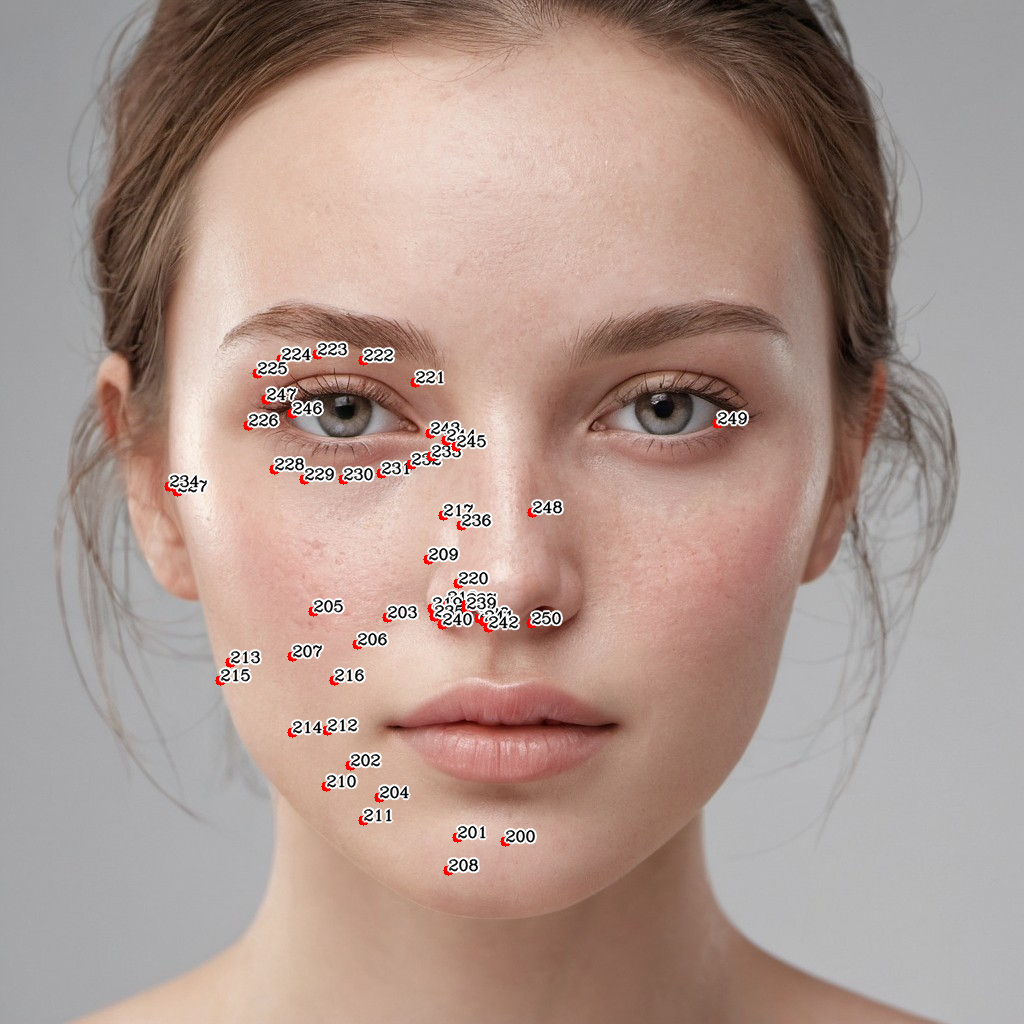

In [5]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow

base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

image = mp.Image.create_from_file("woman1.jpg")

detection_result = detector.detect(image)

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result, regions=['RANGE'], range_start=200, range_end=250)
annotated_image_region = draw_landmarks_on_image(image.numpy_view(), detection_result, regions=[AnatomyMap.LEFT_EYE, AnatomyMap.RIGHT_EYE])

cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
cv2_imshow(cv2.cvtColor(annotated_image_region, cv2.COLOR_RGB2BGR))